## Feedforward Neural Network Implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import copy

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_parquet("costco_2021_reviews_filtered_vectorized_final.parquet")
df

,user_id,name,time,rating,text,pics,resp,gmap_id,vector
0,108341711662008461816,Rod Powell,1580509229183,5,Great service. Nice folks. Very helpful.,None,None,0x88626b6a29df9fb1:0x868c85d23dc91564,"[0.0068788542, 0.029086296, -0.011112881, 0.00..."
1,100886664024661856987,zach smithson,1489608374532,5,Amazing how much cheaper their hearing aids ar...,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x88626b6a29df9fb1:0x868c85d23dc91564,"[-0.05165099, 0.008153723, -0.04912399, 0.0030..."
2,104116808865576923879,George “Stovie” Moore,1623169525640,1,"I find Hoover, Alabama Costco’s tire service t...",None,None,0x888922182c25426d:0xabf1b10efa159b19,"[-0.014003422, 0.008204368, 0.011449834, 0.019..."
3,113636820761208623071,Erica Disbrow,1613357729329,5,"Lambert was so nice, professional, and caring!...",None,None,0x888922182c25426d:0xabf1b10efa159b19,"[-0.010003155, 0.01936056, -0.009762309, 0.020..."
4,101232786196219574483,Roy Martin,1613138521284,5,I needed new tires and Costco's price was $400...,None,None,0x888922182c25426d:0xabf1b10efa159b19,"[-0.043057095, 0.019696508, 0.003782874, 0.008..."
...,...,...,...,...,...,...,...,...,...
788761,108851483128030774999,Odysseas,1458534609705,5,It's Costco.,None,None,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[-0.03667649, -0.01456362, -0.01608518, 0.0076..."
788762,105468512214130057994,Chuck Anderson,1431844304443,5,Outstanding,None,None,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[0.008467636, -0.014427097, -0.027180135, 0.00..."
788763,101071427934910005277,o Abdoko,1417168632053,5,nice place)),None,None,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[-0.034930643, 0.015595584, -0.0100806365, 0.0..."
788764,100180472161950539260,Bill Brasky,1351948282842,5,The actually pay the employees unlike Sams.,None,None,0x8807a8cdc249ad79:0x3fdbf3ca7f0a43bf,"[-0.0036253948, 0.0067303316, -0.025239518, -0..."


In [3]:
X = df[['vector']]
y = df[['rating']]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=123)

# splitting train set and validation set
# then we split it train set into 11-folds to build models

In [5]:
# One hot encoding

ohe_y_train = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_train)
y_train_ohe = ohe_y_train.transform(y_train)

ohe_y_val = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_val)
y_val_ohe = ohe_y_val.transform(y_val)

In [6]:
# 11-fold split

kfold = StratifiedKFold(n_splits=11,
                        shuffle=True,
                        random_state=123)

In [7]:
y_train

,rating
454918,5
650929,3
178555,5
152563,3
164631,5
...,...
597598,5
608852,1
457860,5
132734,5


In [8]:
y_train_ohe

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [9]:
# can note the imbalance of data here

prob = torch.tensor(y_train_ohe).mean(dim=0)
prob

tensor([0.0497, 0.0238, 0.0612, 0.1959, 0.6694], dtype=torch.float64)

In [10]:
# FFN: Linear (1024,6) -> ReLu() -> 2 hidden layers ReLU(Linear(6, 6)) -> Linear(6, 5)

class Multiclass(nn.Module): # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(self):
        super().__init__() # needed to use nn.Module
        self.input = nn.Linear(1024, 6) # input 1024 x 1 column vector
        self.act = nn.ReLU() # activation function
        self.hidden = nn.Linear(6, 6)
        self.output = nn.Linear(6, 5) # output 5 x 1 column vector

    def n_steps(self, x, n):
        for i in range(n):
            x = self.hidden(self.act(x))
        return x

    def forward(self, x):
        x = self.input(x)
        x = self.n_steps(x, 2)
        x = self.act(x)
        x = self.output(x)
        return x

In [11]:
# loss funtion to penalize unbalanced data (ended up not using it as much)

def loss_bal(y_batch):
    prob = y_batch.mean(dim=0)
    expected_value = prob * torch.tensor([1, 2, 3, 4, 5]).sum()
    loss = torch.mean((expected_value - 3)**2)

    return loss

In [12]:
c_entropy = nn.CrossEntropyLoss() # cross entropy loss

In [13]:
loss_bal(torch.tensor(y_train_ohe)) # measuring imbalance of data (0 being perfectly balanced)

tensor(13.1965, dtype=torch.float64)

In [14]:
# tensorize data

X_train_tensor = torch.tensor(X_train.values.tolist(), dtype = torch.float32)
X_val_tensor = torch.tensor(X_val.values.tolist(), dtype = torch.float32)

y_train_ohe_tensor = torch.tensor(y_train_ohe, dtype = torch.float32)
y_val_ohe_tensor = torch.tensor(y_val_ohe, dtype = torch.float32) 

C:\Users\Gil\AppData\Local\Temp\ipykernel_9208\472960837.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X_train_tensor = torch.tensor(X_train.values.tolist(), dtype = torch.float32)


In [15]:
# n_epochs = number of epochs (This doesn't need to be too large because in each epoach there are many updates)
# batch_size: size of each batch = 10
# X_tt, y_tt train sets among X_train, y_train
# X_ho, y_ho validation sets among X_train, y_train (ho for "holdout")

def train_model(model, n_epochs, batch_size, X_tt, y_tt, X_ho, y_ho):

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        
        # set model in training mode and run through each batch
        # batches are paritions of the training set

        model.train()
        n_batches = len(X_tt) // batch_size # number of batches (per epoch)

        with tqdm.trange(n_batches, unit = "batch", mininterval=0) as bar: # bar consists of batches 
            bar.set_description(f"Epoch {epoch}")
            for i in bar:
                # take a batch
                start = i * batch_size
                X_tt_batch = X_tt[start : start + batch_size]
                y_tt_batch = y_tt[start : start + batch_size]

                # forward pass
                y_tt_pred = model(X_tt_batch)
                
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(y_tt_pred, y_tt_batch) # Loss

                # backward pass
                optimizer.zero_grad() # set the grads to none
                loss.backward()

                # update parameters (weight and bias)
                optimizer.step()

                # compute and store metrics
                acc = (torch.argmax(y_tt_batch, 1) == torch.argmax(y_tt_pred, 1)).float().mean()
                epoch_loss.append(float(loss))
                epoch_acc.append(float(acc))

                bar.set_postfix(
                    loss = float(loss),
                    acc = float(acc)
                )
                

        # set model in evaluation mode and run through the test set
        model.eval()
        
        y_pred = model(X_ho)
        ce = c_entropy(y_pred, y_ho) # cross entropy
        acc = (torch.argmax(y_ho, 1) == torch.argmax(y_pred, 1)).float().mean()
        ce = float(ce)
        acc = float(acc)
        
        train_loss_hist.append(np.mean(epoch_loss))
        train_acc_hist.append(np.mean(epoch_acc))
        test_loss_hist.append(ce)
        test_acc_hist.append(acc)
        
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch} validation: Cross-entropy = {ce}, Accuracy = {acc}")

        model.load_state_dict(best_weights)

    return [train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist]

### FFN without Random Undersampling

In [16]:
model = [Multiclass() for i in range(11)]
test_result = []

indices = [[train_index, test_index] for train_index, test_index in kfold.split(X_train, y_train)]
train_indices = list(map(lambda L : L[0], indices))
test_indices = list(map(lambda L : L[1], indices))

In [17]:
for i in range(11):
    print(f"Fold No. {i+1} out of 11 folds")
    X_tt = X_train_tensor[train_indices[i]]
    y_tt = y_train_ohe_tensor[train_indices[i]]

    X_ho = X_train_tensor[test_indices[i]]
    y_ho = y_train_ohe_tensor[test_indices[i]]

    X_tt = X_tt.squeeze(dim=1) # getting rid of extra unwanted dim
    X_ho = X_ho.squeeze(dim=1) 
    
    test_result.append(train_model(model[i], 2, 10, X_tt, y_tt, X_ho, y_ho))
    print()

    # Recall: train_model(model, n_epochs, batch_size, X_tt, y_tt, X_ho, y_ho)


Fold No. 1 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:36<00:00, 367.16batch/s, acc=0.6, loss=0.949]


Epoch 0 validation: Cross-entropy = 0.6596171855926514, Accuracy = 0.7410964965820312


Epoch 1: 100%|██████████| 57364/57364 [02:24<00:00, 395.76batch/s, acc=0.6, loss=0.972]


Epoch 1 validation: Cross-entropy = 0.6559208035469055, Accuracy = 0.7419332265853882

Fold No. 2 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:24<00:00, 398.01batch/s, acc=0.5, loss=1.23] 


Epoch 0 validation: Cross-entropy = 0.6587987542152405, Accuracy = 0.7373485565185547


Epoch 1: 100%|██████████| 57364/57364 [02:29<00:00, 384.31batch/s, acc=0.5, loss=1.25] 


Epoch 1 validation: Cross-entropy = 0.6548859477043152, Accuracy = 0.7385513782501221

Fold No. 3 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:31<00:00, 378.98batch/s, acc=0.5, loss=1.32] 


Epoch 0 validation: Cross-entropy = 0.6596567630767822, Accuracy = 0.7385513782501221


Epoch 1: 100%|██████████| 57364/57364 [02:34<00:00, 371.37batch/s, acc=0.5, loss=1.3]  


Epoch 1 validation: Cross-entropy = 0.6559200286865234, Accuracy = 0.739388108253479

Fold No. 4 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:33<00:00, 373.19batch/s, acc=0.5, loss=1.11] 


Epoch 0 validation: Cross-entropy = 0.7020779848098755, Accuracy = 0.7177721858024597


Epoch 1: 100%|██████████| 57364/57364 [02:37<00:00, 364.36batch/s, acc=0.6, loss=1.11] 


Epoch 1 validation: Cross-entropy = 0.6979532837867737, Accuracy = 0.7192887663841248

Fold No. 5 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:24<00:00, 396.65batch/s, acc=0.6, loss=1.13] 


Epoch 0 validation: Cross-entropy = 0.6539343595504761, Accuracy = 0.7410964965820312


Epoch 1: 100%|██████████| 57364/57364 [02:24<00:00, 395.87batch/s, acc=0.6, loss=1.19] 


Epoch 1 validation: Cross-entropy = 0.6506490111351013, Accuracy = 0.7430837750434875

Fold No. 6 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:25<00:00, 394.01batch/s, acc=0.5, loss=1.23] 


Epoch 0 validation: Cross-entropy = 0.6568612456321716, Accuracy = 0.7403643131256104


Epoch 1: 100%|██████████| 57364/57364 [02:30<00:00, 380.56batch/s, acc=0.5, loss=1.26] 


Epoch 1 validation: Cross-entropy = 0.6543489098548889, Accuracy = 0.7418460845947266

Fold No. 7 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:31<00:00, 378.78batch/s, acc=0.6, loss=1.25] 


Epoch 0 validation: Cross-entropy = 0.9976556301116943, Accuracy = 0.6694151759147644


Epoch 1: 100%|██████████| 57364/57364 [02:33<00:00, 373.29batch/s, acc=0.6, loss=1.25] 



Fold No. 8 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:30<00:00, 380.22batch/s, acc=0.5, loss=1.58] 


Epoch 0 validation: Cross-entropy = 0.9975988268852234, Accuracy = 0.6694151759147644


Epoch 1: 100%|██████████| 57364/57364 [02:32<00:00, 376.56batch/s, acc=0.5, loss=1.58] 



Fold No. 9 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:23<00:00, 398.96batch/s, acc=0.5, loss=1.17] 


Epoch 0 validation: Cross-entropy = 0.6522169709205627, Accuracy = 0.7381110191345215


Epoch 1: 100%|██████████| 57364/57364 [02:29<00:00, 383.74batch/s, acc=0.5, loss=1.07] 


Epoch 1 validation: Cross-entropy = 0.6492276787757874, Accuracy = 0.7395230531692505

Fold No. 10 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:34<00:00, 370.13batch/s, acc=0.6, loss=1.02] 


Epoch 0 validation: Cross-entropy = 0.7033895254135132, Accuracy = 0.720678448677063


Epoch 1: 100%|██████████| 57364/57364 [02:34<00:00, 370.62batch/s, acc=0.6, loss=1.02] 


Epoch 1 validation: Cross-entropy = 0.7012268304824829, Accuracy = 0.7216721177101135

Fold No. 11 out of 11 folds


Epoch 0: 100%|██████████| 57364/57364 [02:23<00:00, 398.77batch/s, acc=0.5, loss=1.19] 


Epoch 0 validation: Cross-entropy = 0.6537984609603882, Accuracy = 0.7416672706604004


Epoch 1: 100%|██████████| 57364/57364 [02:27<00:00, 389.30batch/s, acc=0.5, loss=1.19] 


Epoch 1 validation: Cross-entropy = 0.6496639847755432, Accuracy = 0.7430095672607422



In [19]:
ce = c_entropy(model[8](X_val_tensor).squeeze(dim=1).detach(), y_val_ohe_tensor) # Cross entropy on validation set
print(f"Cross Entropy: {ce}")

Cross Entropy: 0.6515761017799377


In [20]:
# for i in range(11):
#     torch.save(model, f'neural_network_before_undersample_{i+1}.pt')

In [22]:
acc = (y_val_ohe_tensor.argmax(dim=1) == model[8](X_val_tensor).squeeze(dim=1).argmax(dim=1)).float().mean() # Accuracy on validation set
print(f"Accuracy: {acc}")

Accuracy: 0.7386564016342163


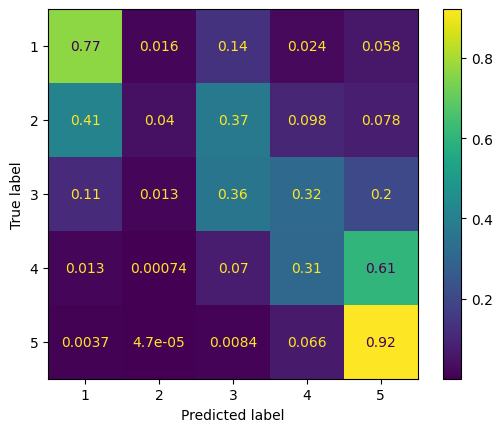

In [23]:
ConfusionMatrixDisplay.from_predictions(
    y_val_ohe_tensor.argmax(dim=1), 
    model[8](X_val_tensor).squeeze(dim=1).argmax(dim=1), 
    normalize = 'true',
    display_labels = [1, 2, 3, 4, 5])
plt.show()

In [24]:
def pos_or_neg(n): # if n is 1 or 2 return 0 else return 1:
    if n == 1 or n == 2:
        return 0
    else:
        return 1

In [26]:
L1 = list(map(pos_or_neg, model[8](X_val_tensor).squeeze(dim=1).argmax(dim=1)))
L2 = list(map(pos_or_neg, y_val_ohe_tensor.argmax(dim=1)))
L = [(L1[i] == L2[i]) * 1.0 for i in range(len(L1))]

In [27]:
sum(L)/len(L) # accuracy by setting 1, 2: 0 and 3, 4, 5: 1

0.9203570115496279

In [29]:
# torch.save(model[8], 'neural_network_before_undersample_best.pt')

In [17]:
model = torch.load('../models/neural_network_before_undersample_best.pt')

In [19]:
y_1 = y_val_ohe_tensor.argmax(dim=1)
y_2 = model(X_val_tensor).squeeze(dim=1).argmax(dim=1)

In [20]:
np.corrcoef(y_1, y_2) # correlation: 0.7826265

array([[1.       , 0.7826265],
       [0.7826265, 1.       ]])

### FFN with Random Undersampling

In [43]:
rus = RandomUnderSampler(random_state = 123)

In [114]:
X_rus_train, y_rus_train = rus.fit_resample(X_train, y_train)

In [186]:
model_rus = [Multiclass() for i in range(11)] # models with random undersampling

In [189]:
test_result_rus = []

for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):

    print(f"Fold No {i+1}")

    X_tt = X_train.iloc[train_index]
    y_tt = y_train.iloc[train_index]

    X_ho = X_train.iloc[test_index]
    y_ho = y_train.iloc[test_index]

    X_rus_tt, y_rus_tt = rus.fit_resample(X_tt, y_tt)

    ohe_y_rus_tt = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_rus_tt)
    y_rus_tt_ohe = ohe_y_rus_tt.transform(y_rus_tt)

    ohe_y_ho = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_ho)
    y_ho_ohe = ohe_y_ho.transform(y_ho)

    X_rus_tt = list(map(lambda x : x.tolist(), X_rus_tt.iloc[:,0].to_list())) # each numpy array needs to be changed into list
    X_ho = list(map(lambda x : x.tolist(), X_ho.iloc[:,0].to_list()))

    X_rus_tt = torch.tensor(X_rus_tt, dtype = torch.float32)
    X_ho = torch.tensor(X_ho, dtype = torch.float32)

    y_rus_tt_ohe = torch.tensor(y_rus_tt_ohe, dtype = torch.float32)
    y_ho_ohe = torch.tensor(y_ho_ohe, dtype = torch.float32)

    test_result_rus.append(train_model(model_rus[i], 2, 10, X_rus_tt, y_rus_tt_ohe, X_ho, y_ho_ohe)) 

    print()
    
# Recall --> train_model(model, n_epochs, batch_size, X_tt, y_tt, X_ho, y_ho):

Fold No 1


Epoch 0: 100%|██████████| 6838/6838 [00:28<00:00, 238.26batch/s, acc=1, loss=0.0828]  


Epoch 0 validation: Cross-entropy = 1.4098495244979858, Accuracy = 0.6694151759147644


Epoch 1: 100%|██████████| 6838/6838 [00:29<00:00, 233.19batch/s, acc=1, loss=0.0135]  



Fold No 2


Epoch 0: 100%|██████████| 6838/6838 [00:28<00:00, 241.62batch/s, acc=1, loss=0.434]   


Epoch 0 validation: Cross-entropy = 1.076777696609497, Accuracy = 0.6694151759147644


Epoch 1: 100%|██████████| 6838/6838 [00:29<00:00, 232.21batch/s, acc=1, loss=0.143]   



Fold No 3


Epoch 0: 100%|██████████| 6838/6838 [00:29<00:00, 234.78batch/s, acc=1, loss=0.222]   


Epoch 0 validation: Cross-entropy = 1.0499894618988037, Accuracy = 0.6694151759147644


Epoch 1: 100%|██████████| 6838/6838 [00:28<00:00, 236.16batch/s, acc=1, loss=0.149]   



Fold No 4


Epoch 0: 100%|██████████| 6838/6838 [00:29<00:00, 235.43batch/s, acc=0, loss=1.24]   


Epoch 0 validation: Cross-entropy = 1.3684524297714233, Accuracy = 0.195851132273674


Epoch 1: 100%|██████████| 6838/6838 [00:29<00:00, 228.12batch/s, acc=1, loss=0.753] 


Epoch 1 validation: Cross-entropy = 1.1032841205596924, Accuracy = 0.6694151759147644

Fold No 5


Epoch 0: 100%|██████████| 6838/6838 [00:28<00:00, 238.17batch/s, acc=1, loss=0.000406]


Epoch 0 validation: Cross-entropy = 3.2785208225250244, Accuracy = 0.6694151759147644


Epoch 1: 100%|██████████| 6838/6838 [00:29<00:00, 232.76batch/s, acc=1, loss=0.000809]



Fold No 6


Epoch 0: 100%|██████████| 6838/6838 [00:29<00:00, 231.46batch/s, acc=1, loss=0.933]  


Epoch 0 validation: Cross-entropy = 1.19319748878479, Accuracy = 0.6694151759147644


Epoch 1: 100%|██████████| 6838/6838 [00:30<00:00, 225.20batch/s, acc=1, loss=0.72]  



Fold No 7


Epoch 0: 100%|██████████| 6838/6838 [00:29<00:00, 233.86batch/s, acc=1, loss=0.0315]  


Epoch 0 validation: Cross-entropy = 1.6034533977508545, Accuracy = 0.6694151759147644


Epoch 1: 100%|██████████| 6838/6838 [00:29<00:00, 229.08batch/s, acc=1, loss=0.0065]  



Fold No 8


Epoch 0: 100%|██████████| 6838/6838 [00:29<00:00, 228.99batch/s, acc=1, loss=1.06]   


Epoch 0 validation: Cross-entropy = 1.25015389919281, Accuracy = 0.6694151759147644


Epoch 1: 100%|██████████| 6838/6838 [00:30<00:00, 223.59batch/s, acc=1, loss=0.744] 



Fold No 9


Epoch 0: 100%|██████████| 6838/6838 [00:30<00:00, 221.85batch/s, acc=1, loss=0.914] 


Epoch 0 validation: Cross-entropy = 1.181389570236206, Accuracy = 0.6694093942642212


Epoch 1: 100%|██████████| 6838/6838 [00:30<00:00, 222.20batch/s, acc=1, loss=0.733] 



Fold No 10


Epoch 0: 100%|██████████| 6838/6838 [00:29<00:00, 232.10batch/s, acc=1, loss=0.61]    


Epoch 0 validation: Cross-entropy = 1.0682010650634766, Accuracy = 0.6694093942642212


Epoch 1: 100%|██████████| 6838/6838 [00:29<00:00, 230.46batch/s, acc=1, loss=0.675] 



Fold No 11


Epoch 0: 100%|██████████| 6838/6838 [00:29<00:00, 233.49batch/s, acc=1, loss=0.848]   


Epoch 0 validation: Cross-entropy = 1.155557632446289, Accuracy = 0.6694093942642212


Epoch 1: 100%|██████████| 6838/6838 [00:29<00:00, 229.10batch/s, acc=1, loss=0.698] 


**Remark**. For the perfectly balanced data (after random undersampling), the FFN does not seem to work properly with StratifiedKFold (or KFold). It seems that the back propogation somehow stops and keeps predicting rating 5 for 100%. (All 11-folds had this issue.)

When we use train_test_split instead of KFold, the FNN did not have the same issue:

In [215]:
test_result_rus = []
model_rus = Multiclass()

X_rus_tt, X_rus_ho, y_rus_tt, y_rus_ho = train_test_split(X_rus_train, y_rus_train, stratify = y_rus_train, test_size = 1/11, random_state = 123)

ohe_y_rus_tt = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_rus_tt)
y_rus_tt_ohe = ohe_y_rus_tt.transform(y_rus_tt)

ohe_y_rus_ho = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_rus_ho)
y_rus_ho_ohe = ohe_y_rus_ho.transform(y_rus_ho)

X_rus_tt = list(map(lambda x : x.tolist(), X_rus_tt['vector'].tolist()))
X_rus_ho = list(map(lambda x : x.tolist(), X_rus_ho['vector'].tolist()))

X_rus_tt = torch.tensor(X_rus_tt, dtype = torch.float32)
X_rus_ho = torch.tensor(X_rus_ho, dtype = torch.float32)

# X_rus_tt = X_rus_tt.squeeze(dim=1) # there is extra dimension (could be a bug with RandomUnderSampler)
# X_rus_ho = X_rus_ho.squeeze(dim=1)

y_rus_tt_ohe = torch.tensor(y_rus_tt_ohe, dtype = torch.float32)
y_rus_ho_ohe = torch.tensor(y_rus_ho_ohe, dtype = torch.float32)

test_result_rus.append(train_model(model_rus, 2, 10, X_rus_tt, y_rus_tt_ohe, X_rus_ho, y_rus_ho_ohe)) 

# Recall: train_model(model, n_epochs, batch_size, X_tt, y_tt, X_ho, y_ho)

Epoch 0: 100%|██████████| 6838/6838 [00:19<00:00, 351.19batch/s, acc=0.8, loss=0.91] 


Epoch 0 validation: Cross-entropy = 1.1183767318725586, Accuracy = 0.5043134689331055


Epoch 1: 100%|██████████| 6838/6838 [00:19<00:00, 351.68batch/s, acc=0.9, loss=0.795]

Epoch 1 validation: Cross-entropy = 1.082909107208252, Accuracy = 0.516157329082489


In [216]:
(y_val_ohe_tensor.argmax(dim=1) == model_rus(X_val_tensor).squeeze(dim=1).argmax(dim=1)).float().mean() # Accuracy on validation set

tensor(0.6455)

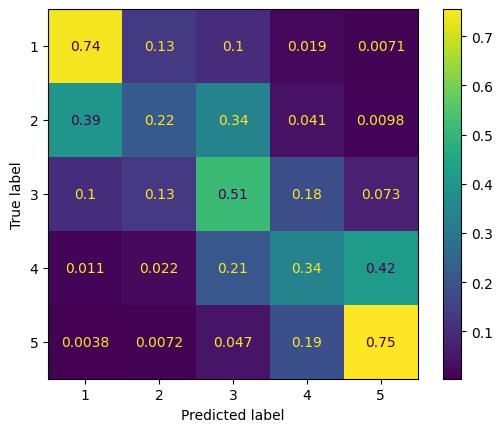

In [217]:
ConfusionMatrixDisplay.from_predictions(
    y_val_ohe_tensor.argmax(dim=1), 
    model_rus(X_val_tensor)[:,0].argmax(dim=1), 
    normalize = 'true',
    display_labels = [1, 2, 3, 4, 5])
plt.show()

In [21]:
model_rus = torch.load('../models/neural_network_after_undersample_with_2_hidden_layers.pt')

In [23]:
# y_1 = y_val_ohe_tensor.argmax(dim=1) # already defined
y_3 = model_rus(X_val_tensor).squeeze(dim=1).argmax(dim=1)

In [24]:
np.corrcoef(y_1, y_3) # correlation 0.75262101

array([[1.        , 0.75262101],
       [0.75262101, 1.        ]])